# Exploratory Data Analysis (EDA)

In [66]:
# Install required libraries (uncomment if running outside Docker)
# !pip install --quiet -r requirements_colab.txt

## Table of Contents

1. **Load DataFrames**
2. **Basic Counts**
3. **Missing & Duplicates**
4. **Category Distribution and Questions with Missing Category**   
5. **Questions whose *question_type* field is *Input***
6. **Real interaction counts per skill**
7. **Answers to questions not found in the **questions_df** dataframe**
8. **star_time* and *end_time* fields NULL**
9. **Cases without the *question_answers* key in the *data_json* field**
10. **Response Durations**
11. **Hit rates by correction, question and category**

## 1. Load DataFrames
First, we need to load the data from the CSV files. The CSV files are in the same directory as this script.<br>
The CSV files are:<br>
    - quizzes.csv: containing the quiz data<br>
    - questions.csv: containing the question data<br>
    - corrections.csv: containing the correction data

In [67]:
import pandas as pd

# Load CSV files into DataFrames
quizzes_df = pd.read_csv("data/quizzes.csv")
questions_df = pd.read_csv("data/questions.csv")
corrections_df = pd.read_csv("data/corrections.csv")

## 2. Basic Counts
We count the number of quizzes, questions, corrections, and unique students in the corrections DataFrame.<br>
This gives us an overview of the data.

In [68]:
print("Quizzes:", len(quizzes_df))
print("Questions:", len(questions_df))
print("Corrections:", len(corrections_df))
print("Unique students:", corrections_df["user_id"].nunique())

Quizzes: 145
Questions: 2405
Corrections: 40193
Unique students: 4952


## 3. Missing & Duplicates
We check for missing values and duplicates in the DataFrames.<br>
    - Missing values are counted for each column.<br>
    - Duplicates are counted for the entire DataFrame.

In [69]:
for df, name in [(quizzes_df, "Quizzes"),
                 (questions_df, "Questions"),
                 (corrections_df, "Corrections")]:
    print(name, "- missing:", df.isna().sum().to_dict())
    print(name, "- duplicates:", df.duplicated().sum())

Quizzes - missing: {'id': 0, 'created_at': 0, 'updated_at': 0, 'curriculum_id': 106, 'online': 0, 'position': 0, 'days_offset': 0, 'name': 0, 'block_access': 0, 'time_allowed': 0, 'start_description': 11, 'in_progress_description': 17, 'end_description': 16, 'overdue_description': 19, 'allow_external_access': 0, 'randomize_questions_order': 0, 'add_as_scored_track': 0, 'weight': 0, 'released_by_staff': 0, 'released_at_specific_time': 0, 'release_time': 0, 'author_id': 56}
Quizzes - duplicates: 0
Questions - missing: {'id': 0, 'created_at': 0, 'updated_at': 0, 'evaluation_quiz_id': 0, 'online': 0, 'position': 0, 'title': 0, 'sub_title': 1083, 'category': 452, 'question_type': 0, 'data_json': 123, 'weight': 0}
Questions - duplicates: 0
Corrections - missing: {'id': 0, 'created_at': 0, 'updated_at': 0, 'user_id': 0, 'batch_evaluation_quiz_item_id': 0, 'start_time': 12190, 'end_time': 12221, 'data_json': 2111, 'skipped': 0, 'skip_not_focus_impact': 0, 'skip_late_impact': 0}
Corrections - d

It can be seen in the previous output that there are several fields that have NULL values, like for example *sub_title*, *category*, *data_json*, *start_time* or *end_time*. 

## 4. Category Distribution and Questions with Missing Category

### Category Distribution

We plot the distribution of categories in the quizzes DataFrame.<br>
This gives us an idea of the distribution of quizzes across different categories.<br>

Number of different categories: 79


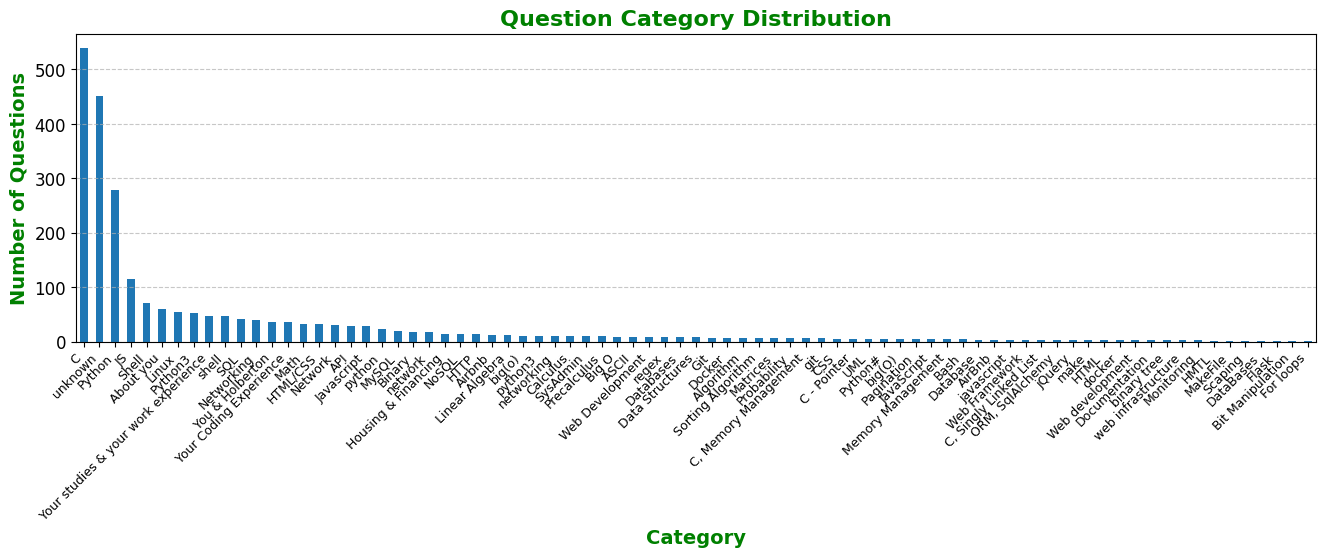

In [70]:
import matplotlib.pyplot as plt
import os

# Count the number of different categories
cat_count = questions_df["category"].nunique()
print("Number of different categories:", cat_count)
print(150 * "=")

# Plot category distribution
cat_dist = (
    questions_df["category"]
    .fillna("unknown")
    .str.strip()
    .value_counts()
)
cat_dist.plot(kind="bar", figsize=(16,4))
plt.title("Question Category Distribution", fontsize=16, fontweight="bold", color="Green")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Category", fontsize=14, fontweight="bold", color="Green")
plt.xticks(fontsize=9)
plt.yticks(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylabel("Number of Questions", fontsize=14, fontweight="bold", color="Green")

# Create the data directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Save the plot as an image
plt.savefig("images/category_distribution.png", bbox_inches="tight", dpi=300)
# Show the plot
plt.show()


What can be observed from the previous graph is that the distribution of the number of questions for each of the 79 categories is very uneven, even showing cases where the same topic is categorized in several different ways. For example, *Python*, *python*, *Python3*, *python3*, and *Python#* represent the same category. <br>
This will need to be taken into consideration when transforming the features to be used in the different Knowledge Tracing models. <br>


In addition, there are categories such as *About you*, *Your studies & your work experience*, *You & Holberton*, *Your Coding Experience*, and *Housing & Financing*, whose questions do not assess any topic in the curriculum. Therefore, these categories will not be considered for Knowledge Tracing models. <br>
On the other hand, corrections that are not classified in any category (category *unknown*) will need to be evaluated in greater detail to determine whether or not they will be considered.

### Questions with Missing Category

Now I plan to analyze the uncategorized questions to better understand which questions to consider and which not. To do this, I begin by determining how many questions don't have an assigned category and printing them out for later analysis.

In [71]:
# Configure pandas display options to show all columns
pd.set_option("display.max_columns", None)  # Will show all columns
pd.set_option("display.width", 1000)        # Will not wrap lines
pd.set_option("display.colheader_justify", "center")  # Center column headers

# First we start by finding out how many questions do not have a category.
uncategorized_questions = questions_df[questions_df["category"].isna()]
uncategorized_questions_count = len(uncategorized_questions)

# Finally, we print the uncategorized questions
print("Number of uncategorized questions:", uncategorized_questions_count)
print(150 * "=")
print(uncategorized_questions.head(20))

Number of uncategorized questions: 452
     id       created_at           updated_at       evaluation_quiz_id  online  position                                                         title                                                                                                                                                                                 sub_title                                                                                                                          category  question_type                                                                                                                          data_json                                                                                                                           weight
0      1  2018-06-08 06:18:13  2019-01-05 01:24:50           1             1         1                                                                                     What C book did you choose to read?             

Let's separate the analysis of questions without a previous category by the *question_type* field, since, when looking at the *data_json* field, it would seem that some question types have no relation to any study curriculum.

Let's first analyze the cases where the *question_type* field is *SelectMultiple*: 

In [72]:
# Let's first filter the uncategorized_questions dataframe by the "question_type" field, which is "SelectMultiple"
uncategorized_questions_select_multiple = uncategorized_questions[
    uncategorized_questions["question_type"] == "SelectMultiple"
]

# We select final columns to show
final = uncategorized_questions_select_multiple[[
    'id',
    'evaluation_quiz_id',
    'title',
    'sub_title',
    'question_type',
    'data_json',
]]

# We print the filtered data frame
print("Uncategorized questions with question_type 'SelectMultiple':")
print(final.to_string(index=False))

Uncategorized questions with question_type 'SelectMultiple':
 id   evaluation_quiz_id                                                        title                                                                                                                                                                                                                                                sub_title                                                                                                                                                                                        question_type                                                                                                                                                   data_json                                                                                                                                                 
   1           1                                                                                          

After analyzing all the uncategorized questions whose *question_type* is *SelectMultiple* it can be observed that only the question whose *id* is 1061 (What is Betty) seems to belong to the curriculum, but the information in the *data_json* field of the same is empty, so I decide to discard all the answers associated with said questions in the dataframe **corrections_df**, as well as the rows corresponding to said questions in the dataframe **questions_df**, which will be done during the ETL (Extract, Transform, Load).

Now let's analyze the cases where the *question_type* field is *Input*:

In [73]:
# Let's first filter the uncategorized_questions dataframe by the "question_type" field, which is "Input"
uncategorized_questions_input = uncategorized_questions[
    uncategorized_questions["question_type"] == "Input"
]

# We select final columns to show
final = uncategorized_questions_input[[
    'id',
    'evaluation_quiz_id',
    'title',
    'sub_title',
    'question_type',
    'data_json',
]]

# We print the filtered data frame
print("Uncategorized questions with question_type 'Input':")
print(final.to_string(index=False))

Uncategorized questions with question_type 'Input':
 id   evaluation_quiz_id                                                                                                                                                               title                                                                                                                                                                                                                                              sub_title                                                                               question_type  data_json  
   2           1                                                                                                                                                                                                                                                                                           How much time did you spend reading these books?                                                            

It can be seen that in the case where the *question_type* field is *Input*, the questions also do not correspond to any topic in the curriculum. Furthermore, it can be seen that in most cases the *data_json* field is NaN, which leads me to want to analyze all questions whose *question_type* field is *Input* (not just those with the *unknown* category), to see if they can also be discarded, which will be done later.<br>
For now, I will discard all the answers associated with said questions (where the *question_type* field is *Input* and the *category* field is *unknown*), in the dataframe **corrections_df**, as well as the rows corresponding to said questions in the dataframe **questions_df**

Similarly, we do the same to analyze the case where the category is *unknown* and the *question_type* field is *Select*:

In [74]:
# Let's first filter the uncategorized_questions dataframe by the "question_type" field, which is "Select"
uncategorized_questions_select = uncategorized_questions[
    uncategorized_questions["question_type"] == "Select"
]

# We select final columns to show
final = uncategorized_questions_select[[
    'id',
    'evaluation_quiz_id',
    'title',
    'sub_title',
    'question_type',
    'data_json',
]]

# We print the filtered data frame
print("Uncategorized questions with question_type 'Select':")
print(final.to_string(index=False))

Uncategorized questions with question_type 'Select':
 id   evaluation_quiz_id                                                  title                                                                  sub_title                 question_type                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      data_json                                                                                                                                                                                                                                                                                            

It can be observed that in the case where the *question_type* field is *Select*, the questions also do not correspond to any topic in the curriculum. Furthermore, it can be seen that in all cases, the *data_json* field does not contain information about questions that can be categorized as correct or incorrect. So, I decide to discard all the answers associated with said questions in the dataframe **corrections_df**, as well as the rows corresponding to said questions in the dataframe **questions_df**. 

We do the same to analyze the case where the category is *unknown* and the *question_type* field is *Scored*:

In [75]:
# Let's first filter the uncategorized_questions dataframe by the "question_type" field, which is "Scored"
uncategorized_questions_scored = uncategorized_questions[
    uncategorized_questions["question_type"] == "Scored"
]

# We select final columns to show
final = uncategorized_questions_scored[[
    'id',
    'evaluation_quiz_id',
    'title',
    'sub_title',
    'question_type',
    'data_json',
]]

# We print the filtered data frame
print("Uncategorized questions with question_type 'Scored':")
print(final.to_string(index=False))

Uncategorized questions with question_type 'Scored':
 id   evaluation_quiz_id                                                                                 title                                                                                 sub_title question_type                                                                                                                                              data_json                                                                                                                                              
 185           5                                                                                                                                                         I make friends easily    NaN        Scored              {"items":[{"value":"Very much like me","score":0,"random":false},{"value":"Mostly like me","score":0,"random":false},{"value":"Somewhat like me","score":0,"random":false},{"value":"Not much like me","score":0,"rand

Again, it can be seen that in the case where the *question_type* field is *Scored*, the questions also do not correspond to any topic in the curriculum; therefore, as in the other cases, the answers to questions of this type will be discarded in the **corrections_df** dataframe, as will the questions themselves in the **questions_df** dataframe.

Finally, we do the same to analyze the case where the category is *unknown* and the *question_type* field is *Checkbox*:

In [76]:
# Let's first filter the uncategorized_questions dataframe by the "question_type" field, which is "Checkbox"
uncategorized_questions_checkbox = uncategorized_questions[
    uncategorized_questions["question_type"] == "Checkbox"
]

# We select final columns to show
final = uncategorized_questions_checkbox[[
    'id',
    'evaluation_quiz_id',
    'position',
    'title',
    'sub_title',
    'question_type',
    'data_json',
]]

# We print the filtered data frame
print("Uncategorized questions with question_type 'Checkbox':")
print(final.sort_values(by=['evaluation_quiz_id', 'position']).to_string(index=False))

Uncategorized questions with question_type 'Checkbox':
 id   evaluation_quiz_id  position                                                                                                                                             title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   sub_title                                                                                                                                                                                 

From the above, it can be observed that in most cases, the questions corresponding to the same quiz (field *evaluation_quiz_id*) correspond to the same topic of a study curriculum (Python, C, Shell, Git, etc.), so I will choose to categorize each of the questions manually. For another instance of the project, a method such as Natural Language Processing can be applied, based on the title, subtitle and letter of the question, as well as from the name and description of the quiz, in order to determine the category of those questions that were not categorized when the quiz was created.

After analyzing each of the questions where the category is *unknown* and the *question_type* field is *Checkbox*, I obtained the following results, where the *evaluation_quiz_id* corresponding to each topic is indicated, and in some cases (questions with *evaluation_quiz_id* 64 and 145), the *position* of the quiz questions corresponding to the topic is also indicated:

- python: 15, 35 43, 62, 65, 129
- shell: 48, 64(1, 2, 14 al 19, 21), 66, 144, 145(1 al 4, 7 al 9, 11, 14 al 17)
- c: 49, 53, 59, 68, 69, 75, 92, 114, 133, 143
- git: 57, 64(3 al 13), 145(5, 6, 10, 12, 13)
- html/css: 72
- sql: 74
- jquery: 95
- web development: 113
- to eliminate: 38, 106, 149

Each category of type *unknown* and whose *question_type* field is *Checkbox*, will be renamed as specified above.

It can be observed that there are questions (with *evaluation_quiz_id* 38, 106 and 149) for which the answers to said questions will be eliminated in the dataframe **corrections_df**, as well as said questions in the dataframe **questions_df**, since they do not correspond to any topic in the study curricula or are test questions.

## 5. Questions whose *question_type* field is *Input*

Now we will analyze all those questions whose category is not *unknown* (since they have already been analyzed), and whose value of the *question_type* field is *input*, since although there are questions that correspond to some topic of the study curriculum, it could be observed that in most cases the *data_json* field is NaN.

In [77]:
# Filter questions with non-unknown category and type "Input"
mask_input = (
    (~questions_df["category"].isna()) &
    (~questions_df['category'].str.lower().isin(["about you",
                                                 "your studies & your work experience",
                                                 "you & holberton",
                                                 "your coding experience",
                                                 "housing & financing"])) &
    (questions_df['question_type'].str.lower() == 'input')
)
input_qs = questions_df[mask_input]

# Print total count
print("Total questions with category ≠ 'unknown' and type 'Input':", len(input_qs))

# Show first 25 for manual inspection
display(input_qs[['id','category','question_type','data_json']].reset_index(drop=True))

Total questions with category ≠ 'unknown' and type 'Input': 36


,id,category,question_type,data_json
0,2187,Python,Input,NaN
1,2188,Python,Input,NaN
2,2189,Python,Input,NaN
3,2190,Databases,Input,NaN
4,2191,Python,Input,NaN
5,2192,Shell,Input,NaN
6,2193,Web Framework,Input,NaN
7,2194,Web Framework,Input,NaN
8,2195,Web Framework,Input,NaN
9,2196,Web Development,Input,NaN


As expected, since the *question_type* field is equal to *input*, all *data_json* fields are NaN. Examining the questions that meet this condition, we can see that they are essay questions, and therefore, in principle, we cannot grade them as correct or incorrect.
For another instance of the project, a method such as Natural Language Processing can be applied based on the answers each student enters to determine whether the answer entered was correct or incorrect, for example. Therefore, for a first instance of the project, we will choose to delete both the answers and questions whose *question_type* field value is *input*.

## 6. Real interaction counts per skill

In this section, we'll analyze the total number of interactions and unique students for each category. Total interactions represent the total number of times any student answered any question labeled with that category. It tells us how many examples we have to train the model on that skill.
On the other hand, unique students represent the number of students who have practiced that skill at least once. It tells us how diverse the student population is in that category.

A category with very few interactions does not provide enough examples for the model to learn reliable patterns (risk of overfitting), while with few individuals represented, the model might learn specific behaviors from one or two students, and will not generalize well to new students.

In [78]:
import json

# We filter only the rows with data_json present
valid_json_corrections = corrections_df.dropna(subset=['data_json']).copy()

# Copy the questions_df to avoid modifying the original DataFrame
questions_norm = questions_df.copy()

# Normalization of the category
questions_norm['category'] = questions_norm['category'].fillna("unknown").str.strip().str.lower()

# Explode valid_json into one row per answer
rows = []
for _, corr in valid_json_corrections.iterrows():
    user = corr['user_id']
    try:
        data = json.loads(corr['data_json'])
    except:
        continue
    for ans in data.get('question_answers', []):
        if 'id' not in ans:
            continue
        rows.append({
            'user_id':     user,
            'question_id': int(ans['id'])
        })

interactions = pd.DataFrame(rows)

# Join to questions_df on question_id → get category_norm
interactions = interactions.merge(
    questions_norm[['id','category']],
    left_on='question_id',
    right_on='id',
    how='left'
).drop(columns=['id'])

# Aggregate per skill
skill_stats = interactions.groupby('category').agg(
    interactions=('question_id','count'),
    students   =('user_id',   lambda s: s.nunique())
).reset_index()

pd.set_option("display.max_rows", None)  # Will show all rows

# Show skills
display(skill_stats.sort_values('interactions', ascending=False).reset_index(drop=True))


,category,interactions,students
0,c,260999,3375
1,python,64865,2831
2,unknown,58877,3429
3,linux,28437,2683
4,math,24795,2256
5,html/css,24425,2228
6,shell,22534,2153
7,sql,20081,2464
8,about you,19749,2260
9,your studies & your work experience,14864,2244


The intention would be to discard categories whose *interactions* value is less than 200 or whose *students* value is less than 30.
- **≥ 200 interactions:** Ensures that we have a minimum of ~200 response examples for that skill. With that, we can start training without the dataset being too small. <br>
- **≥ 30 distinct students:** Ensures that these examples come from at least 30 different users, which provides diversity and reduces bias toward patterns from a handful of students.

For the current categories, I would have to discard the last 13 categories, but since I will be using more general categories, which will group several of the current categories, then I will have to analyze again the total interactions and the unique students for each new category, which I will do during the ETL once I group all the categories into more general categories.

## 7. Answers to questions not found in the **questions_df** dataframe

We want to analyze whether there are answers to questions, where the *id* of the same does not correspond to any question in the dataframe **questions_df**.<br>
This could be due to the fact that the question was deleted from the **questions_df** dataframe, but the answers were not deleted from the **corrections_df** dataframe. <br>

In [79]:
# We filter only the rows with data_json present
valid_json_corrections = corrections_df.dropna(subset=['data_json']).copy()

# Copy the questions_df to avoid modifying the original DataFrame
questions_copy = questions_df.copy()

# We mark with True/False if the key "question_answers" appears in that string
mask_has_key = valid_json_corrections['data_json'].str.contains(
    '"question_answers"', na=False
)

# We create another mask in which, in addition, that list is not empty
def has_nonempty_qa(js):
    try:
        arr = json.loads(js).get('question_answers', [])
        return isinstance(arr, list) and len(arr) > 0
    except:
        return False

mask_nonempty = valid_json_corrections['data_json'].apply(has_nonempty_qa)

# We combine both (both are Series of booleans)
mask_has_qa = mask_has_key & mask_nonempty

valid_corr = valid_json_corrections[mask_has_qa].copy()

# Build a set of all valid question IDs
valid_qids = set(questions_copy['id'].astype(int).tolist())

# For each correction, we extract the list of IDs from question_answers
def extract_qids(js):
    try:
        arr = json.loads(js).get('question_answers', [])
        return [int(item.get('id')) for item in arr if 'id' in item]
    except:
        return []

valid_corr['all_qids'] = valid_corr['data_json'].apply(extract_qids)

# We detect for each row those qids that are NOT in valid_qids
def invalid_qids(qid_list):
    return [qid for qid in qid_list if qid not in valid_qids]

valid_corr['invalid_qids'] = valid_corr['all_qids'].apply(invalid_qids)

# We filter rows where invalid_qids is not empty
mask_invalid = valid_corr['invalid_qids'].apply(lambda lst: len(lst) > 0)
invalid_corr = valid_corr[mask_invalid]

# We print totals and first 25 rows
print("Total responses with IDs not associated with any question:", 
      invalid_corr['invalid_qids'].map(len).sum())
print(250 * "=")
print("\nFirst 25 corrections containing invalid IDs:")
print(
    invalid_corr
      .loc[:, ['id','user_id','all_qids','invalid_qids','data_json']]
      .head(25)
      .to_string(index=False)
)

# We print a list of the unique invalid_qids
invalid_qids_list = invalid_corr['invalid_qids'].explode().unique()
print(250 * "=")
print("List of invalid IDs:")
print(invalid_qids_list)

Total responses with IDs not associated with any question: 2026

First 25 corrections containing invalid IDs:
  id   user_id                                                  all_qids                                                 invalid_qids                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

After verifying, directly in the tables, that the questions with id 551, 1055, 1332, 1913, 1914, 1915, 1916, 1917, 2005 and 2003 do not exist, and at the same time, considering the need to have information about the questions and to be able to obtain the information about the category to which each answer corresponds (which is linked through the *evaluation_quiz_id* field of the **questions_df** dataframe), then I decide to eliminate the answers whose id is not present in the **questions_df** dataframe during the ETL.

I would also like to analyze if there are any questions in the dataframe **questions_df** whose value in the field *evaluation_quiz_questions* does not correspond to any id in the dataframe **quizzes_df**:

In [80]:
# We build the set of valid quiz IDs
valid_quiz_ids = set(quizzes_df['id'].astype(int).tolist())

# We filtered out the rows in questions_df with invalid evaluation_quiz_id
mask_orphan_questions = ~questions_df['evaluation_quiz_id'].astype(int).isin(valid_quiz_ids)
orphan_questions = questions_df.loc[mask_orphan_questions]

# We show how many questions do not have a valid evaluation_quiz_id
print(f"Total questions with invalid evaluation_quiz_id: {len(orphan_questions)}\n")


Total questions with invalid evaluation_quiz_id: 0



Since the result is zero, we do not proceed to analyze the need to eliminate any quiz.

## 8. *star_time* and *end_time* fields NULL

Now we'll analyze the *star_time* and *end_time* fields in the **corrections_df** dataframe where the values ​​are NULL. To do this, we first filter the rows in the **corrections_df** dataframe where the *data_json* field is NULL, which would correspond to cases where the student did not complete the assessment.

In [81]:
# We filter only the rows with data_json present
valid_json = corrections_df.dropna(subset=['data_json']).copy()

# Define mask for missing timestamps
mask_ts_null = corrections_df['start_time'].isna() | corrections_df['end_time'].isna()

# Define mask for records whose JSON contains "question_answers"
def has_question_answers(js):
    try:
        data = json.loads(js)
        return ('question_answers' in data) and (data['question_answers'] != [])
    except:
        return False

mask_qa = corrections_df['data_json'].apply(has_question_answers)

# Filter: missing start/end AND has question_answers key
filtered = corrections_df[mask_ts_null & mask_qa].copy()

# Extract the FIRST question_id from question_answers
def extract_first_qid(js):
    try:
        data = json.loads(js)
        qa = data.get('question_answers', [])
        if qa and isinstance(qa[0], dict):
            return int(qa[0].get('id'))
    except:
        pass
    return None

filtered['question_id'] = filtered['data_json'].apply(extract_first_qid)

# Build lookup maps from questions_df
qid_to_quiz     = questions_df.set_index('id')['evaluation_quiz_id'].to_dict()
qid_to_category = questions_df.set_index('id')['category'].to_dict()

# Map quiz_id and category into filtered
filtered['quiz_id']  = filtered['question_id'].map(qid_to_quiz)
filtered['category']= filtered['question_id'].map(qid_to_category)
filtered['correction_id'] = filtered['id']

# Select and print the desired columns
cols = ['correction_id', 'question_id', 'quiz_id', 'category', 'start_time', 'end_time', 'data_json']
print("Corrections with missing timestamps, having QA, enriched with quiz_id & category:")
print(filtered[cols].to_string(index=False))

Corrections with missing timestamps, having QA, enriched with quiz_id & category:
 correction_id  question_id  quiz_id   category       start_time     end_time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Now we filter out the rows that do not have a category assigned, so we can better analyze the information stored in the *data_json* field:

In [82]:
# Define the “core” categories to keep
core_categories = ['Math', 'Python', 'Precalculus', 'Calculus', 'C']

# Filter out corrections whose category is in core_categories
out_of_scope = filtered[~filtered['category'].isin(core_categories)].copy()

# Show a summary of the result
print(f"Total corrections outside core categories: {len(out_of_scope)}")
# Select and print the desired columns
cols = ['question_id', 'quiz_id', 'category', 'start_time', 'end_time', 'data_json']
# Print key columns
print(out_of_scope[['correction_id', 'question_id', 'quiz_id', 'category', 'start_time', 'end_time', 'data_json']].to_string(index=False))

Total corrections outside core categories: 9
 correction_id  question_id  quiz_id category      start_time     end_time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Based on the above information, I decide to discard the rows with *correction_id* values ​​of 5560, 5570, and 8363, since none of these corrections correspond to questions that assess a topic in the curriculum. <br>
Although the quizzes in the cases mentioned above contain unanswered questions that do assess a topic in the curriculum, in the first instance, I will not consider unanswered questions. I will only consider answers that I can confirm were correct or incorrect.<br>
I do not discard the other corrections, since some of the answers correspond to questions that are related to a topic in the curriculum. <br>
In those cases where I do not discard the correction, and since these corrections do not have a value in the *end_time* field, I will consider the total quiz time as the response time, since I do not have information on how long it took the student to complete the quiz. I will do this during the ETL.<br>


## 9. Cases without the *question_answers* key in the *data_json* field

What I want to analyze now are the corrections that do not have the *question_answers* key in the *data_json* field of the corrections_df dataframe.

In [83]:
# We filter only the rows with data_json present
valid_json = corrections_df.dropna(subset=['data_json']).copy()

# Define a helper to test for the presence of "question_answers"
def has_question_answers(json_str):
    try:
        data = json.loads(json_str)
        return "question_answers" in data
    except Exception:
        return False  # malformed or null JSON

# Build a mask of rows missing that key
mask_missing = ~valid_json["data_json"].apply(has_question_answers)

# Count how many are missing
count_missing = mask_missing.sum()
print(f"Number of corrections without 'question_answers': {count_missing}")
print(150 * "=")

# Display the first 20 rows that lack the key
print("\nFirst 20 corrections missing 'question_answers':")
print(valid_json[mask_missing].head(20))

Number of corrections without 'question_answers': 10103

First 20 corrections missing 'question_answers':
       id       created_at           updated_at       user_id  batch_evaluation_quiz_item_id      start_time            end_time                                             data_json                                        skipped  skip_not_focus_impact  skip_late_impact
369    456  2018-12-03 08:05:43  2019-01-21 21:15:32    323                  18               2019-01-18 17:17:31  2019-01-21 21:15:32                                                                      {"is_overdue":1}     0               0                    0       
3765  4342  2020-03-12 06:05:45  2021-04-23 23:57:13    852                 413                               NaN                  NaN                      {"question_order":[324,327,325,318,319,326,323,321,320,317,322]}     1               0                    0       
3926  4520  2020-03-12 06:07:01  2021-04-10 05:10:00   1490                 168  

Since there are 10103 corrections without the *question_answers* key in the *data_json* field, I then proceeded to analyze the *data_json* field of these corrections directly in MySQL Workbench, using the following SQL code:<br>


```sql
-- 1) Counting corrections do not have the "question answers" key in the "data_json" field
SELECT 
  COUNT(*) AS missing_or_invalid
FROM 
  evaluation_quiz_corrections
WHERE 
  data_json IS NOT NULL
  AND data_json != ''
  AND JSON_VALID(data_json) != 0
  AND JSON_CONTAINS_PATH(data_json, 'one', '$.question_answers') = 0
;

-- 2) View all rows that do not have the "question answers" key in the "data_json" field
SELECT 
  id,
  user_id,
  batch_evaluation_quiz_item_id,
  start_time,
  end_time,
  data_json
FROM 
  evaluation_quiz_corrections
WHERE 
  data_json IS NOT NULL
  AND data_json != ''
  AND JSON_VALID(data_json) != 0
  AND JSON_CONTAINS_PATH(data_json, 'one', '$.question_answers') = 0
;
```


What I was looking for was to verify that, in all these cases, the corrections do not contain information about the answers to the quiz questions.<br>
In most cases, the output is of the form '{"question_order":[324,327,325,318,319,326,323,321,320,317,322]}' or of the form '{"is_overdue":1}'.<br>
It can be seen that these are cases where the student did not answer any questions or missed the assessment deadline.<br>
Since in these cases there is no information about the student's answers and I am not initially going to consider the unanswered questions, I decided to discard all of these cases for training the Knowledge Tracing models.

## 10. Response Durations

First, we will analyze the null values ​​in the *start_time* and *end_time* fields of the **corrections_df** dataframe, since these fields are important to calculate the response time for each question. We also determine the minimum and maximum duration of the quizzes in seconds.

In [84]:
# We convert with str.strip() and explicit formatting, to avoid extra spaces
corrections_df['start_time'] = pd.to_datetime(
    corrections_df['start_time'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)
corrections_df['end_time'] = pd.to_datetime(
    corrections_df['end_time'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)

# We count the nulls again
print("start_time nulls:", corrections_df['start_time'].isna().sum())
print("end_time   nulls:", corrections_df['end_time'].isna().sum())

# We filter only the rows with present times
valid = corrections_df.dropna(subset=['start_time','end_time']).copy()

# We recalculate the duration
valid['duration_sec'] = (
    valid['end_time'] - valid['start_time']
).dt.total_seconds()
valid['duration_min'] = (
    valid['end_time'] - valid['start_time']
).dt.total_seconds() / 60


# We round the duration_sec column to 0 decimal places and convert it to int
valid['duration_sec'] = valid['duration_sec'].round(0).astype(int)

# We round the duration_min column to 0 decimal places and convert it to int
valid['duration_min'] = valid['duration_min'].round(0).astype(int)

# We look at some unique values
print("Non-null durations:", valid['duration_min'].notna().sum())
print("Some duration samples in seconds:", valid['duration_sec'].unique()[:10])
print(f"Minimum duration in seconds: {valid['duration_sec'].min()} s")
print(f"Maximum duration in seconds: {valid['duration_sec'].max()} s")


start_time nulls: 12190
end_time   nulls: 12221
Non-null durations: 27972
Some duration samples in seconds: [ 961 1332 1804 1654 2019 1614 1064 1544 1834 2226]
Minimum duration in seconds: 4 s
Maximum duration in seconds: 1031040 s


### Explore the distribution and detect outliers

Next, we will explore the distribution of the response times to see if there are any outliers. We will use an histogram to visualize the distribution and identify any potential outliers.

Duration percentiles (sec):
 5%=91, 25%=509, 50%=951, 75%=1561, 95%=2915, 99%=3817


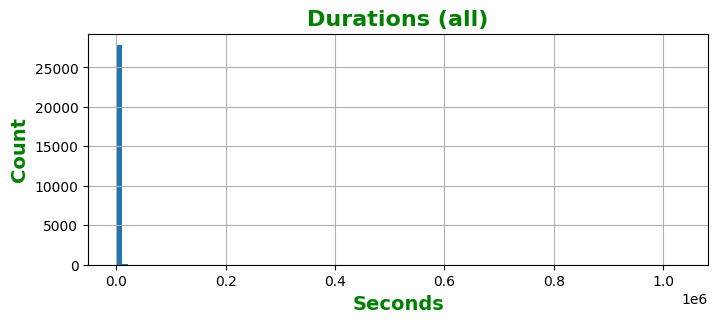

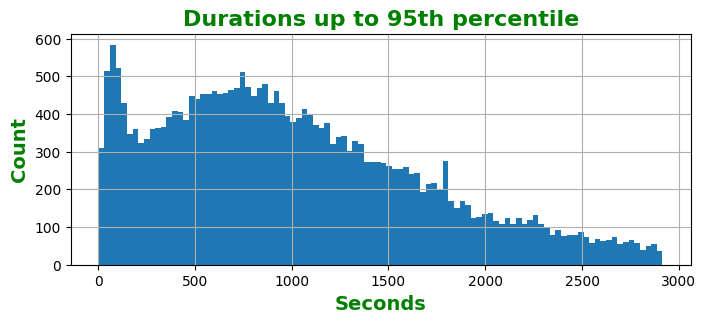

In [85]:
import numpy as np

# We calculate some key percentiles
p05, p25, p50, p75, p95, p99 = np.percentile(valid['duration_sec'], [5,25,50,75,95,99])
print(f"Duration percentiles (sec):\n 5%={p05:.0f}, 25%={p25:.0f}, 50%={p50:.0f}, 75%={p75:.0f}, 95%={p95:.0f}, 99%={p99:.0f}")

# Full histogram on linear scale
plt.figure(figsize=(8,3))
valid['duration_sec'].hist(bins=100)
plt.title("Durations (all)", fontsize=16, fontweight="bold", color="Green")
plt.ylabel("Count", fontsize=14, fontweight="bold", color="Green")
plt.xlabel("Seconds", fontsize=14, fontweight="bold", color="Green")
plt.show()

# Histogram zoom to 95th percentile
plt.figure(figsize=(8,3))
valid[valid['duration_sec'] <= p95]['duration_sec'].hist(bins=100)
plt.title("Durations up to 95th percentile", fontsize=16, fontweight="bold", color="Green")
plt.ylabel("Count", fontsize=14, fontweight="bold", color="Green")
plt.xlabel("Seconds", fontsize=14, fontweight="bold", color="Green")
plt.show()



Quick Interpretation:
Median (P50): ~951s (≈16 minutes)

95th Percentile: ~2915s (≈48 minutes)

99th Percentile: ~3817s (≈1 hour and 3 minutes)

This indicates that:

- The vast majority of students completed the quiz in less than 1 hour.

- Values ​​above this are rare and likely reflect interruptions or long sessions that do not correspond to a typical attempt.

### Winsorize (capping to that value)

Now, let's cap the values ​​to the 99th percentile. This means that any value above the 99th percentile will be set to the value of the 99th percentile itself. This is a technique to handle outliers in data.

Percentile 99 duration in minutes: 64 min


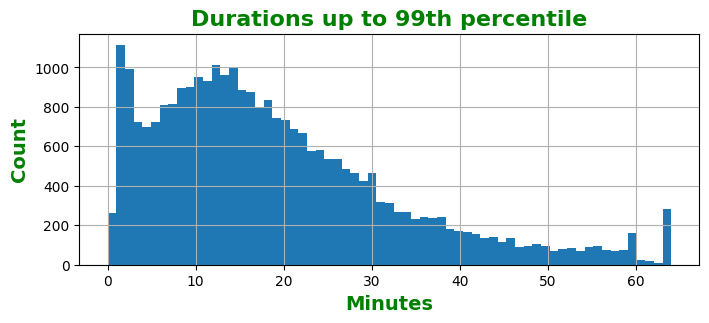

In [86]:
#We convert to minutes the p99 value
p99_min = (p99 / 60).round(0).astype(int)
print(f"Percentile 99 duration in minutes: {p99_min} min")

valid['duration_min_capped'] = valid['duration_min'].clip(upper=p99_min)

# Histogram zoom to 95th percentile
plt.figure(figsize=(8,3))
valid['duration_min_capped'].hist(bins=65)
plt.title("Durations up to 99th percentile", fontsize=16, fontweight="bold", color="Green")
plt.ylabel("Count", fontsize=14, fontweight="bold", color="Green")
plt.xlabel("Minutes", fontsize=14, fontweight="bold", color="Green")

# Save the plot as an image
plt.savefig("images/durations_99_percentile.png", bbox_inches="tight", dpi=300)

plt.show()

### Identify and display Winsorized values

Then, we will identify the values that were capped and display them. This will help us understand how many values were affected by the capping process and what those values were.

In [87]:
# Filter the rows where winsorization was applied
winsorized_rows = valid[valid['duration_min'] > p99_min].copy()

# Show number of modified values
print(f"Number of Winsorized Values: {len(winsorized_rows)}")

# An ID or index identifier is displayed. We assume it is the original index of the file.
print("Winsorized value IDs:")
print(winsorized_rows.id.tolist())

# They are sorted by descending original duration and the 20 largest values ​​are displayed.
top_winsorized = winsorized_rows.sort_values(by='duration_min', ascending=False).head(25)

top_winsorized['correction_id'] = top_winsorized['id']

print(1000 * "=")
# Relevant columns are displayed
print(top_winsorized[['correction_id', 'user_id', 'start_time', 'end_time', 'data_json', 'duration_min']])


Number of Winsorized Values: 271
Winsorized value IDs:
[348, 355, 429, 456, 1263, 1346, 1463, 1595, 1597, 1850, 1856, 1866, 1887, 1893, 2368, 2411, 3728, 3730, 3921, 3986, 4049, 4232, 5117, 5508, 5523, 5532, 5588, 5593, 5741, 5836, 5948, 6003, 6375, 6459, 7810, 7950, 7995, 8073, 8074, 8361, 8600, 8681, 9497, 9845, 10860, 10886, 10932, 10980, 11006, 11011, 11014, 11019, 11033, 11062, 11076, 12065, 12094, 12114, 12220, 12240, 12265, 12277, 12519, 13045, 13119, 13158, 13311, 13411, 13415, 13441, 13731, 13787, 13982, 13984, 14520, 14522, 14524, 14551, 14556, 14564, 14644, 14676, 14701, 14710, 14719, 14782, 14800, 14808, 14809, 14829, 14856, 14876, 14890, 14892, 14900, 15299, 15343, 16633, 16757, 16975, 17003, 17055, 17064, 17454, 17455, 17464, 17581, 17582, 17717, 18335, 18424, 18738, 18742, 18879, 18926, 18930, 19208, 19288, 19373, 19526, 19635, 19661, 19676, 19701, 19754, 20242, 20250, 20271, 20343, 20533, 20559, 20996, 20999, 21096, 21098, 21099, 21101, 21103, 21105, 21106, 21107, 21918

In [88]:
# We define a new function that first looks for 'question_order',
# then 'question_answers', and returns None if nothing is found.
def get_first_question_id(data_json_str):
    try:
        obj = json.loads(data_json_str)
    except Exception:
        return None

    # Case 1: question order
    if 'question_order' in obj and isinstance(obj['question_order'], list) and obj['question_order']:
        return obj['question_order'][0]

    # Case 2: list of answers
    if 'question_answers' in obj and isinstance(obj['question_answers'], list) and obj['question_answers']:
        first = obj['question_answers'][0]
        # A veces el id puede estar dentro de un diccionario
        if isinstance(first, dict) and 'id' in first:
            return first['id']

    # Case 3: We cannot extract an id
    return None

# We start from your DataFrame winsorized_rows or top_winsorized
compare = valid.copy()  # or top_winsorized

# We extract the first_qid using the function
compare['first_qid'] = compare['data_json'].apply(get_first_question_id)

# We removed rows where we could not extract any valid questions
compare = compare[compare['first_qid'].notna()]

# We map question_id → quiz_id
quiz_map = questions_df.set_index('id')['evaluation_quiz_id']
compare['quiz_id'] = compare['first_qid'].astype(int).map(quiz_map)

# We removed corrections that could not be mapped to any quiz.
compare = compare[compare['quiz_id'].notna()]


compare['quiz_id'] = compare['quiz_id'].astype(int)

# We define metadata of the quiz (days_offset, time_allowed)
quiz_meta = quizzes_df.set_index('id')[['days_offset','time_allowed']]
compare = compare.join(quiz_meta, on='quiz_id')

# We rename columns
compare['time_allowed_min'] = compare['time_allowed']
compare['time_allowed_sec'] = compare['time_allowed'] * 60
compare['correction_id'] = compare['id']

# We sort and keep the 25 longest ones
result = compare.sort_values('duration_min', ascending=False).head(25)

# We select the final columns
final = result[[
    'correction_id',
    'quiz_id',
    'duration_min',
    'days_offset',
    'time_allowed_min'
]]

display(final.reset_index(drop=True))

,correction_id,quiz_id,duration_min,days_offset,time_allowed_min
0,9845,11,17184,10,60
1,45593,49,10244,0,60
2,20533,12,10192,27,60
3,12265,1,10006,1,60
4,30512,63,6118,0,60
5,32195,105,5593,0,60
6,45619,49,4992,0,60
7,27830,58,4457,0,60
8,5532,3,3264,1,30
9,14809,27,2747,0,0


### Difference between time_allowed and days_offset

Now we want to analyze if there is a direct correlation between the difference in the values ​​of the columns duration_min and time_allowed_min and between the values ​​of the column days_offset.

Corrections exceeding time: 2610
Max overrun (s): 17124
Mean overrun (s): 67.70689655172414
Correlation between days_offset and overrun: 0.014865236819247467


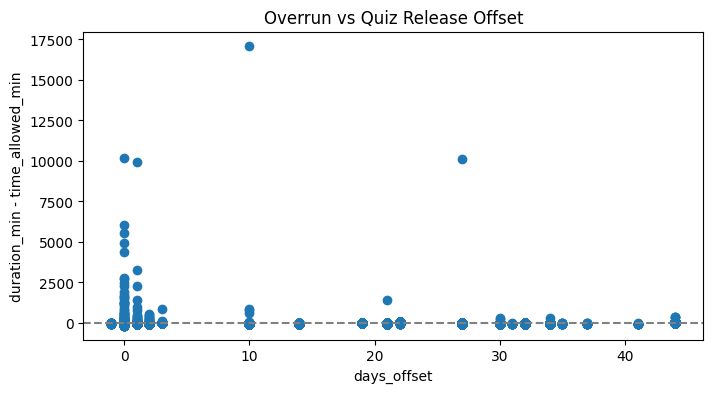

In [89]:
compare_duration = compare.copy()
compare_duration['delta_min'] = compare_duration['duration_min'] - compare_duration['time_allowed']

print("Corrections exceeding time:", (compare_duration['delta_min'] > 0).sum())
print("Max overrun (s):", compare_duration['delta_min'].max())
print("Mean overrun (s):", compare_duration.loc[compare_duration['delta_min']>0,'delta_min'].mean())

corr = compare_duration['days_offset'].corr(compare_duration['delta_min'])
print("Correlation between days_offset and overrun:", corr)

# Scatter: days_offset vs delta_s
plt.figure(figsize=(8,4))
plt.scatter(compare_duration['days_offset'], compare_duration['delta_min'])
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('days_offset')
plt.ylabel('duration_min - time_allowed_min')
plt.title('Overrun vs Quiz Release Offset')

# Save the plot as an image
plt.savefig("images/overrun_vs_days_offset.png", bbox_inches="tight", dpi=300)

plt.show()

As we can see, there is no direct correlation between the difference in the values ​​of the columns duration_min and time_allowed_min and between the values ​​of the column days_offset.

### Creating the <i>estimated_duration</i> column

Finally, we will create a new column called estimated_duration in the **corrections_df** dataframe, field that corresponds to the allowed time of the quiz in case the duration is longer than the allowed time, or to the actual time of the quiz otherwise. This will help us better understand the estimated duration of each quiz attempt.

In [90]:
def estimate_duration_sec(row):
    """ This function estimates the duration in seconds based on the time allowed and actual duration. """
    if row['time_allowed'] == 0:
        # no time limit → keep actual duration
        return row['duration_sec']
    elif row['duration_min'] > row['time_allowed']:
        # overruns a timed quiz → cap at time_allowed_min
        return row['time_allowed'] * 60
    else:
        # within allowed time → keep actual duration
        return row['duration_sec']

def estimate_duration_min(row):
    """ This function estimates the duration in minutes based on the time allowed and actual duration. """
    if row['time_allowed'] == 0:
        # no time limit → keep actual duration
        return row['duration_min']
    elif row['duration_min'] > row['time_allowed']:
        # overruns a timed quiz → cap at time_allowed_min
        return row['time_allowed']
    else:
        # within allowed time → keep actual duration
        return row['duration_min']

# We apply the estimation functions to the DataFrame
compare['estimated_duration_sec'] = compare.apply(estimate_duration_sec, axis=1)
compare['estimated_duration_min'] = compare.apply(estimate_duration_min, axis=1)

# We sort the DataFrame by 'duration_sec' in descending order
# and select the relevant columns
result = compare.sort_values('duration_sec', ascending=False)

final_head = result[[
    'correction_id',
    'quiz_id',
    'duration_min',
    'time_allowed_min',
    'estimated_duration_min'
]]

# We display the first 20 rows of the result
print("Head of result:")
display(final_head.head(20).reset_index(drop=True))
print(80*"=")

# We select the last 20 rows of the result
# and display the relevant columns
final_tail = result[[
    'correction_id',
    'quiz_id',
    'duration_sec',
    'time_allowed_sec',
    'estimated_duration_sec'
]]
print("Tail of result:")
display(final_tail.tail(20).reset_index(drop=True))

Head of result:


,correction_id,quiz_id,duration_min,time_allowed_min,estimated_duration_min
0,9845,11,17184,60,60
1,45593,49,10244,60,60
2,20533,12,10192,60,60
3,12265,1,10006,60,60
4,30512,63,6118,60,60
5,32195,105,5593,60,60
6,45619,49,4992,60,60
7,27830,58,4457,60,60
8,5532,3,3264,30,30
9,14809,27,2747,0,2747


Tail of result:


,correction_id,quiz_id,duration_sec,time_allowed_sec,estimated_duration_sec
0,14265,26,12,1800,12
1,14194,26,12,1800,12
2,31621,96,11,0,11
3,10115,26,11,1800,11
4,31638,96,11,0,11
5,31639,96,11,0,11
6,31643,96,11,0,11
7,10107,26,11,1800,11
8,14090,26,11,1800,11
9,31668,96,10,0,10


When you need to consider the estimated time duration of a quiz, the value of the *duration_min* column or the value of the *time_allowed_min* column will be considered, depending on which of the two values is greater. For this purpose a new column named *duration* will be created during the ETL process.

Duration percentiles (sec):
 5%=91, 25%=508, 50%=951, 75%=1560, 95%=2887, 99%=3600


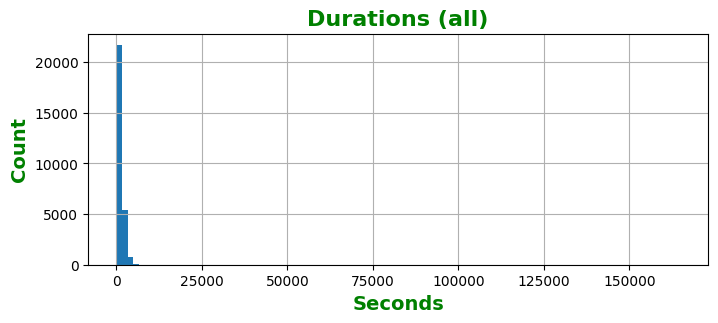

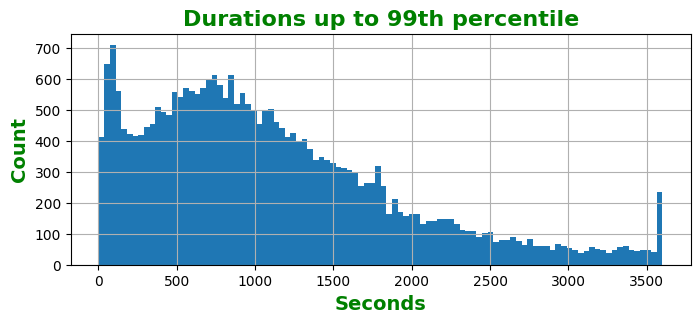

In [91]:
# We calculate some key percentiles
p05, p25, p50, p75, p95, p99 = np.percentile(compare['estimated_duration_sec'], [5,25,50,75,95,99])
print(f"Duration percentiles (sec):\n 5%={p05:.0f}, 25%={p25:.0f}, 50%={p50:.0f}, 75%={p75:.0f}, 95%={p95:.0f}, 99%={p99:.0f}")

# Full histogram on linear scale
plt.figure(figsize=(8,3))
compare['estimated_duration_sec'].hist(bins=100)
plt.title("Durations (all)", fontsize=16, fontweight="bold", color="Green")
plt.ylabel("Count", fontsize=14, fontweight="bold", color="Green")
plt.xlabel("Seconds", fontsize=14, fontweight="bold", color="Green")
plt.show()

# Histogram zoom to 99th percentile
plt.figure(figsize=(8,3))
compare[compare['estimated_duration_sec'] <= p99]['estimated_duration_sec'].hist(bins=100)
plt.title("Durations up to 99th percentile", fontsize=16, fontweight="bold", color="Green")
plt.ylabel("Count", fontsize=14, fontweight="bold", color="Green")
plt.xlabel("Seconds", fontsize=14, fontweight="bold", color="Green")

# Save the plot as an image
plt.savefig("images/durations_99_percentile_2.png", bbox_inches="tight", dpi=300)

plt.show()

Por lo tanto, a la hora de necesitar considerar el tiempo estimado de duración de un quiz, se procederá a considerar únicamente el 99th percentil de los datos correspondientes a la columna *duration* ya que existen valores demasiados altos que no corresponden a un tiempo real de duración del quiz. <br>

## 11. Hit rates by correction, question and category

The goal of calculating hit rates is to quantify, for each question—and then for each category—what proportion of answers were correct. This helps us to: <br>

- Identify easy or difficult questions: If a question has a hit rate close to 1.0, almost everyone answers it correctly; if it's close to 0.0, almost no one gets it right.

- Detect problematic categories: By aggregating these hit rates by category, you can see if there are subject areas where students consistently underperform.

- Inform feature engineering: Difficulty (1–hit_rate) could be used as a feature in models such as PFA.

### Hit rates by correction

First, we will calculate the hit rates for each correction. This will give us an idea of how well students performed on each quiz. <br>
The hit rate is calculated as the number of correct answers divided by the total number of questions in the quiz. <br>

In [92]:
import json

rates = valid.copy()

def extract_scores(json_str):
    try:
        data = json.loads(json_str)
        # 'question_answers' es una lista de dicts, cada uno tiene 'id' y 'score'
        return [int(ans["score"]) for ans in data.get("question_answers", [])]
    except:
        return []

# Extraemos de data_json la lista de scores para cada corrección
rates["scores"] = rates["data_json"].apply(extract_scores)

# Number of correct answers (>0)
rates["num_correct"] = rates["scores"].apply(lambda lst: sum(1 for s in lst if s > 0))

# Number of wrong answers (<0)
rates["num_incorrect"] = rates["scores"].apply(lambda lst: sum(1 for s in lst if s < 0))

# Number of skips or blanks (==0)
rates["num_blank"] = rates["scores"].apply(lambda lst: sum(1 for s in lst if s == 0))

rates['correction_id'] = rates['id']

# We sort and keep the 25 longest ones.
result = rates.head(25)

# We select final columns
final = result[[
    'correction_id',
    'scores',
    'num_correct',
    'num_incorrect',
    'num_blank',
]]

display(final.reset_index(drop=True))


,correction_id,scores,num_correct,num_incorrect,num_blank
0,5,"[0, 0, 1, 0, 0, 1, 0, 0, -1, 1, 0, 0, 1, -1, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, -1, 0, 0, 0, -1, -1, 1, -1, -1, 1, -1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 1, 0, 0, 0, -1, 0, 0, 0, 0]",13,12,51
1,6,"[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 0, 0, 0, -1, 0, -1, -1, 0, 0, 0, 0, -1, 1, 1, 0, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 0, -1, -1, 1, 1, -1, 1, 0, 0, 1, 1, -1, 1, 0, -1, -1, 1, 1, -1, 1, -1, -1, -1, 0, 1, 0]",40,18,18
2,7,"[0, 0, 1, 1, 1, 0, 1, -1, 1, 0, 1, -1, 1, 1, 1, 1, -1, -1, 0, 1, 0, -1, 0, 1, 0, 0, 0, -1, 1, 1, 1, 0, 1, 1, 1, 1, 1, -1, -1, -1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, 1, 0, 0, -1, -1, 1, -1, 0, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 0, 1, 1, 0]",40,17,19
3,8,"[0, 0, 1, 1, 1, 1, 1, -1, 0, 1, 1, -1, 1, 1, -1, 1, 0, 1, 0, 1, 1, 1, -1, -1, 0, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 0, 1, 1, 1, 0, -1, 0, -1, -1, 0, 1, 1, -1, 0, 0, -1, 0, 0, 1, 0, -1, 1, 0, 1, 0, 1, 1, 0, -1, -1, -1, -1]",38,20,18
4,9,"[0, 0, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 0, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 0, 1, 1, -1, 1, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 1, 0, -1, 1, -1, -1, 1, 0, 1, -1, -1, -1, -1,...",30,31,15
5,10,"[0, 0, 1, 1, 1, 0, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 0, 0, 1, 1, 1, 1, -1, 1, 1, 0, 1, -1, 1, 1, 1, 1, 1, -1, 1]",60,9,7
6,11,"[0, 0, 0, 1, 1, 0, 1, -1, 0, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, -1, 1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, -1, -1, -1, 0, 1, 0, 1, -1, 0, 0, -1, 0, 0]",30,12,34
7,12,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1]",65,9,2
8,13,"[0, 0, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1]",57,17,2
9,14,"[0, 0, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1]",54,20,2


### Hit rates by question

Now, we will calculate the hit rates for each question. This will help us identify which questions are easy or difficult. <br>
The hit rate is calculated as the number of correct answers divided by the total number of answers for that question. <br>

In [93]:
def extract_qids(json_str):
    """ Extracts question IDs from the JSON string in data_json. """
    try:
        data = json.loads(json_str)
        # Extracts the "id" field from each element in question_answers
        return [int(ans["id"]) for ans in data.get("question_answers", [])]
    except:
        return []

rates["qids"] = rates["data_json"].apply(extract_qids)

# We explode both lists and then group by qids
# and scores to calculate the hit rate
exploded = rates.explode(["qids","scores"])
exploded = exploded.dropna(subset=["qids","scores"])
exploded["scores"] = exploded["scores"].astype(int)

# We group by qids and calculate the hit rate
# (number of correct answers / total number of answers)
hit_rate_per_question = (
    exploded
      .groupby("qids")["scores"]
      .apply(lambda s: (s > 0).mean())
      .rename("hit_rate")
      .reset_index()
      .rename(columns={"qids":"question_id"})
)
condition_patial_hits = (hit_rate_per_question['hit_rate'] > 0) & (hit_rate_per_question['hit_rate'] < 1)
condition_no_hits = hit_rate_per_question['hit_rate'] == 0
condition_full_hits = hit_rate_per_question['hit_rate'] == 1
print("Total Cuestions: ", len(hit_rate_per_question))
print("Total Cuestions with partial hits: ", len(hit_rate_per_question[condition_patial_hits]))
print("Total Cuestions with no hits: ", len(hit_rate_per_question[condition_no_hits]))
print("Total Cuestions with 100% hits: ", len(hit_rate_per_question[condition_full_hits]))

# We extract only the two columns that are needed from questions_df
q_meta = questions_df[['id','data_json']].rename(columns={'id':'question_id'})

# We merge the question meta and join it to the hit_rate table.
hit_rate_per_question = (
    hit_rate_per_question
      .merge(q_meta, on='question_id', how='left')
)


pd.set_option("display.max_colwidth", 250)

print(275 * "=")
print("Hit rate per cuestion: ")
print(hit_rate_per_question.head(25))
print(275 * "=")
print("Cuestions with partial hits: ")
print(hit_rate_per_question[condition_patial_hits].head(25))
print(275 * "=")
print("Cuestions with no hits: ")
print(hit_rate_per_question[condition_no_hits].head(25))
print(275 * "=")
print("Cuestions with 100% hits: ")
condition = hit_rate_per_question['hit_rate'] == 1
print(hit_rate_per_question[condition_full_hits].head(25))

Total Cuestions:  2062
Total Cuestions with partial hits:  1727
Total Cuestions with no hits:  301
Total Cuestions with 100% hits:  34
Hit rate per cuestion: 
    question_id  hit_rate                                                                                                                         data_json                                                                                                                         
0        1       0.000000                                                                                                                                              {"items":["The C Programming Language","Programming in C","Head First C","I didn’t read one of these books"]}
1        2       0.000000                                                                                                                                                                                                                                                        NaN
2        3

During the ETL process the hit rate value will be used as a way to inject the "difficulty" of the question as a feature to Knowledge Tracing models, especially to PFA or any model that wants to weight questions according to how easy or difficult they are.
To do this, the hit rate value will be used as 1 - hit rate, since the hit rate is a value between 0 and 1, and subtracting this value from 1 gives a value that represents how difficult the question is. <br>
That value will be stored in the *difficulty* column of the **corrections_df** dataframe.

What can be seen in the above output is that if hit_rate is equal to zero, then it would seem that the field *value* is not observed in the *items* list of the *data_json* dictionary.


### Verification of the previous hypothesis

Now let's verify the previous hypothesis that if the *hit_rate* is equal to zero, then the *value* field is not observed in the *items* list of the *data_json* dictionary. For this, we are going to filter out the cases where the *hit_rate* is equal to zero and then we are going to count how many times the *value* field appears in the *items* list of the *data_json* dictionary.<br>

In [94]:
# Filter only those with hit_rate==0
zeros = hit_rate_per_question[hit_rate_per_question['hit_rate'] == 0].copy()

# Function that checks if in "items" there are dicts with key "value".
def has_value_field(json_str):
    try:
        data = json.loads(json_str)
        items = data.get('items', [])
        for it in items:
            if isinstance(it, dict) and 'value' in it:
                return True
        return False
    except Exception:
        return False

# Apply and count
zeros['has_value'] = zeros['data_json'].apply(has_value_field)

total_zero = len(zeros)
with_value  = zeros['has_value'].sum()
without     = total_zero - with_value

print(f"Total questions with hit_rate=0: {total_zero}")
print(f"- With 'value' in items : {with_value}")
print(f"- Without 'value' in items: {without}")

# Display the question IDs with 'value' in items
print("\nQuestion IDs with 'value' in items:")
print( zeros.loc[zeros['has_value'], 'question_id'].tolist() )

Total questions with hit_rate=0: 301
- With 'value' in items : 22
- Without 'value' in items: 279

Question IDs with 'value' in items:
[185, 187, 188, 190, 193, 194, 195, 197, 199, 201, 202, 203, 205, 208, 209, 210, 644, 693, 818, 883, 1534, 2114]


In [95]:
# Extract the list of question_ids that meet has_value=True
qids_with_value = zeros.loc[zeros['has_value'], 'question_id'].tolist()

questions = questions_df.copy()

# Filter questions_df by these IDs and get the desired columns
filtered_questions = (
    questions
      .loc[questions['id'].isin(qids_with_value), 
           ['id', 'category', 'title', 'data_json']]
      .rename(columns={'id': 'question_id'})
)

# Show the result
print(filtered_questions.reset_index(drop=True))


    question_id category                        title                                                                                                                                                data_json                                                                                                                         
0       185         NaN                                I make friends easily  {"items":[{"value":"Very much like me","score":0,"random":false},{"value":"Mostly like me","score":0,"random":false},{"value":"Somewhat like me","score":0,"random":false},{"value":"Not much like me","score":0,"random":false},{"value":"Not like me...
1       187         NaN             I dislike being the center of attention.  {"items":[{"value":"Very much like me","score":0,"random":false},{"value":"Mostly like me","score":0,"random":false},{"value":"Somewhat like me","score":0,"random":false},{"value":"Not much like me","score":0,"random":false},{"value":"Not like me...
2       188     

What can be observed in the above output is that for all those questions whose category is an empty string (NaN), the questions do not correspond to any curriculum, they are rather personal questions or there is even a test question from the platform (question_id=883). However, there are other valid questions where it can be observed that they are really situations where all the students simply answered the question wrong.